# Import Libraries

In [4]:
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load Data

In [2]:
df = pd.read_csv("Data/diabetes_prediction_dataset_cleaned.csv")
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Define categorical & numerical columns


In [3]:
categorical_cols = ['gender', 'smoking_history']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Data preprocessing

In [4]:
#  convert categorical columns by one-hot encoding 
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
# this is smote that used to balance the dataset through oversampling
smote = SMOTE(random_state=42)


# Evaluation Function

In [7]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n {model_name} Evaluation")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_proba):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()


# Models 

In [8]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6],
            'classifier__learning_rate': [0.01, 0.1]
        }
    }
}

results = {}
best_models = {}

# Train and Evaluate Models


Training and Evaluating: Logistic Regression
Cross-validated ROC-AUC scores: [0.95790459 0.96198216 0.9640852  0.96237632 0.96018277]
Mean ROC-AUC: 0.9613
Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Best ROC-AUC Score: 0.9613

 Logistic Regression Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.42      0.89      0.57      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.89      0.75     20000
weighted avg       0.94      0.89      0.90     20000

ROC-AUC Score: 0.9621428158148506


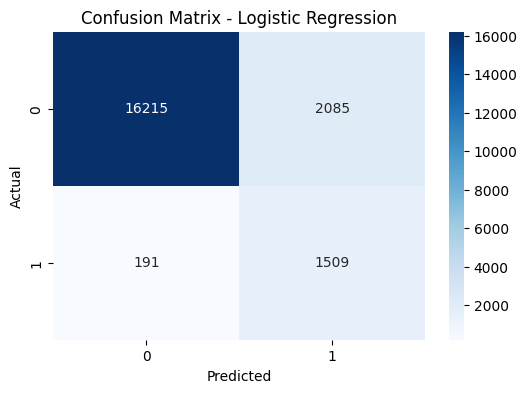

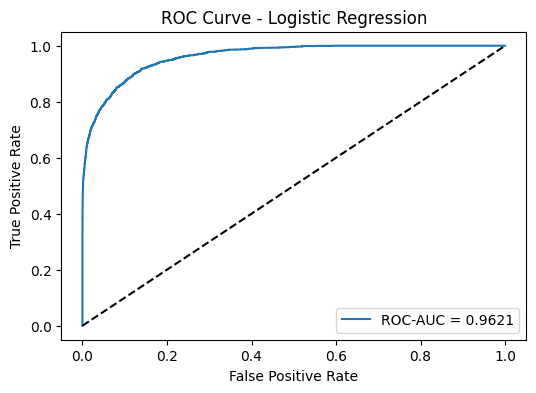


Training and Evaluating: Random Forest
Cross-validated ROC-AUC scores: [0.95916669 0.96162214 0.96634852 0.96683291 0.9644198 ]
Mean ROC-AUC: 0.9637
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC-AUC Score: 0.9723

 Random Forest Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18300
           1       0.51      0.88      0.65      1700

    accuracy                           0.92     20000
   macro avg       0.75      0.90      0.80     20000
weighted avg       0.95      0.92      0.93     20000

ROC-AUC Score: 0.972514545162327


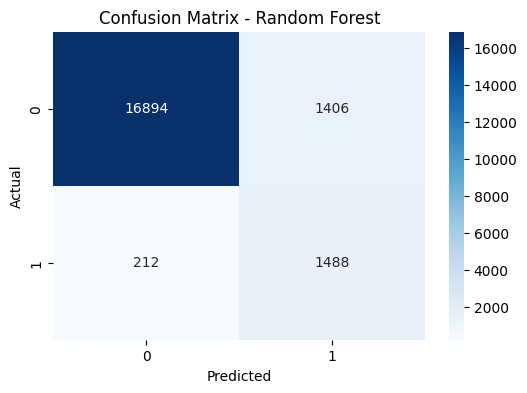

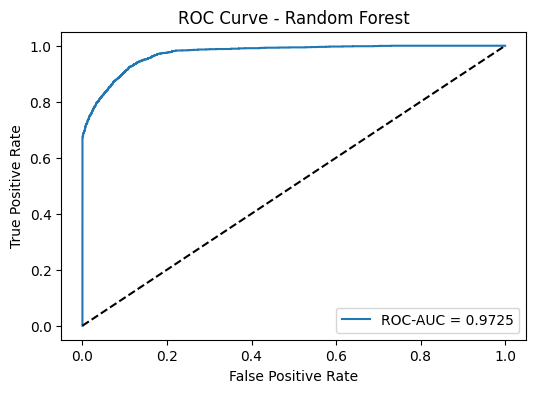


Training and Evaluating: XGBoost


C:\Users\youss\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:47:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\youss\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:47:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\youss\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:47:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\youss\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:48:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Cross-validated ROC-AUC scores: [0.97363019 0.9752672  0.97847381 0.97721116 0.97643018]
Mean ROC-AUC: 0.9762


C:\Users\youss\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:48:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best ROC-AUC Score: 0.9776

 XGBoost Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.82      0.75      0.78      1700

    accuracy                           0.96     20000
   macro avg       0.90      0.87      0.88     20000
weighted avg       0.96      0.96      0.96     20000

ROC-AUC Score: 0.9777650594664096


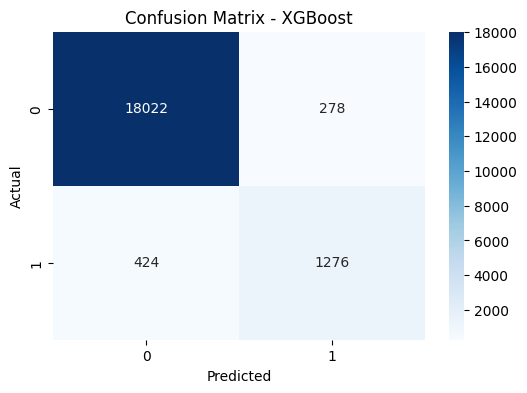

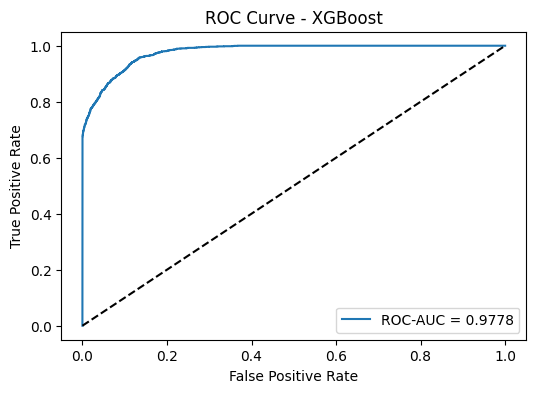

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model_info in models.items():
    print(f"\nTraining and Evaluating: {name}")
    
    # Create pipeline with SMOTE
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('smote', smote),
        ('classifier', model_info["model"])
    ])
    
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"Cross-validated ROC-AUC scores: {scores}")
    print(f"Mean ROC-AUC: {np.mean(scores):.4f}")
    
    # Hyperparameter tuning
    grid_search = GridSearchCV(
        pipeline,
        param_grid=model_info["params"],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")
    
    # Evaluate best model
    best_model = grid_search.best_estimator_
    evaluate_model(best_model, X_test, y_test, name)
    
    results[name] = grid_search.best_score_
    best_models[name] = best_model


# Feature Importance

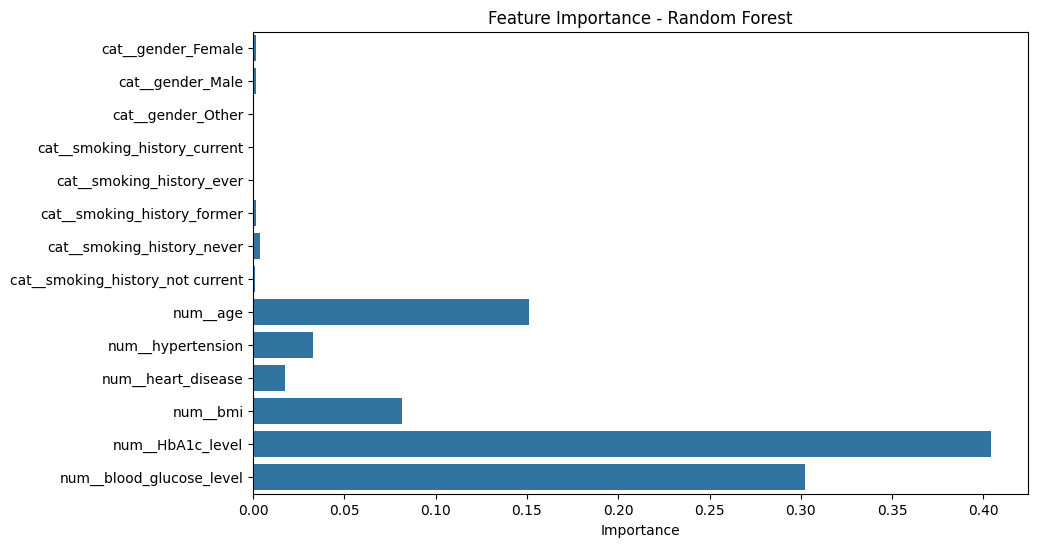

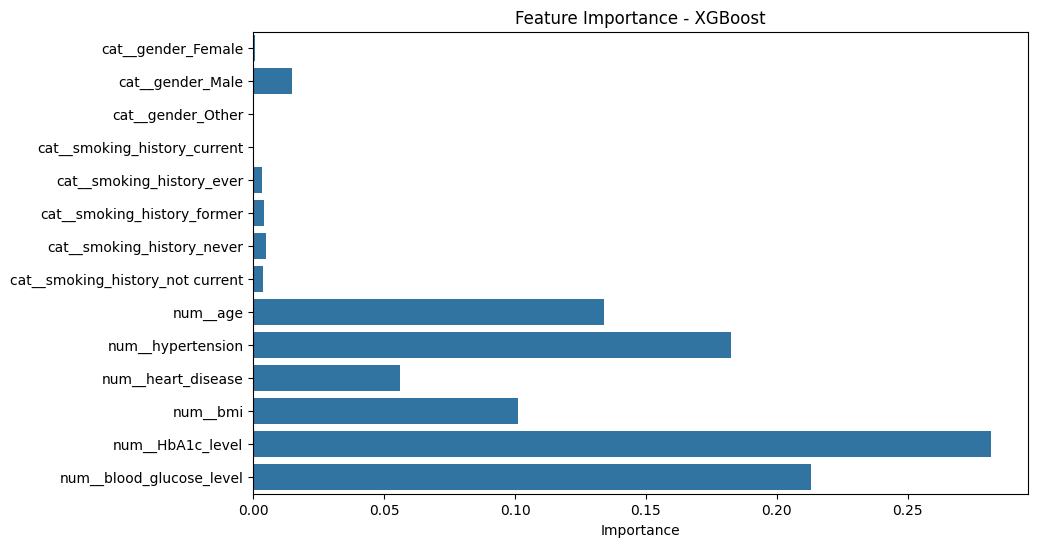

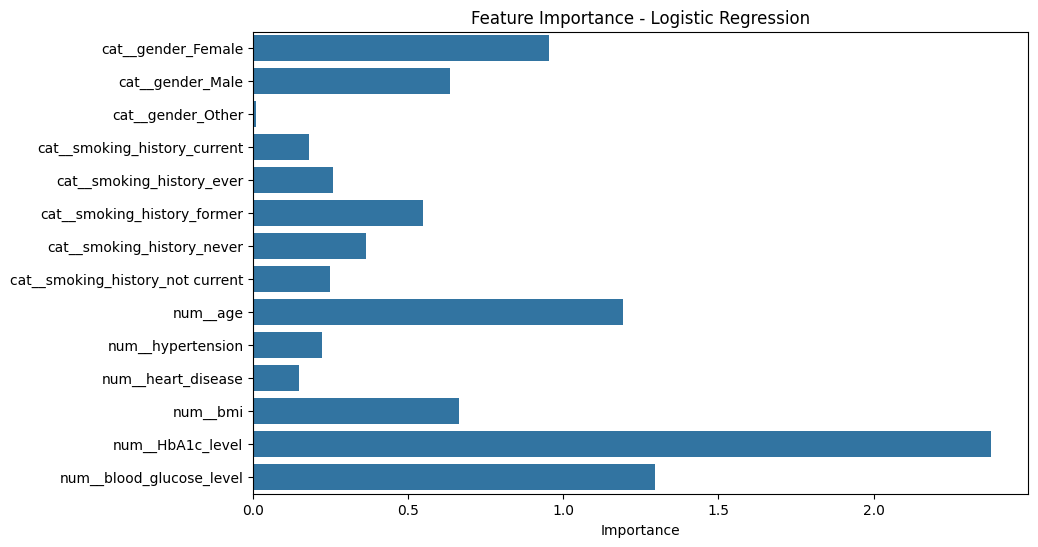

In [10]:
# for name in ["Random Forest", "XGBoost"]:
#     model = best_models[name]
#     feature_names = (model.named_steps['preprocessing']
#                      .get_feature_names_out())
#     importances = model.named_steps['classifier'].feature_importances_
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=importances, y=feature_names)
#     plt.title(f"Feature Importance - {name}")
#     plt.xlabel("Importance")
#     plt.show()
#############
for name in ["Random Forest", "XGBoost", "Logistic Regression"]:
    model = best_models[name]
    feature_names = model.named_steps['preprocessing'].get_feature_names_out()
    
    # Check if the classifier has feature_importances_ or coef_
    classifier = model.named_steps['classifier']
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])  # Take absolute values of coefficients
    else:
        print(f"Feature importance is not available for {name}.")
        continue
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title(f"Feature Importance - {name}")
    plt.xlabel("Importance")
    plt.show()

# Compare Models

<Figure size 800x500 with 0 Axes>

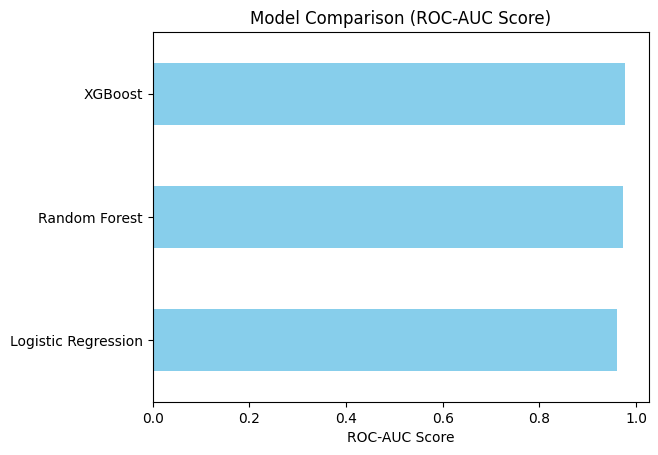

In [11]:

# --- Compare Models ---
comparison_df = pd.DataFrame.from_dict(results, orient='index', columns=['ROC-AUC Score'])
comparison_df.sort_values(by='ROC-AUC Score', ascending=True, inplace=True)
plt.figure(figsize=(8, 5))
comparison_df.plot(kind='barh', legend=False, title="Model Comparison (ROC-AUC Score)", color='skyblue')
plt.xlabel("ROC-AUC Score")
plt.show()



# Best Model

In [12]:
best_model_name = comparison_df.idxmax()['ROC-AUC Score']
print(f"\nBest Model: {best_model_name} with ROC-AUC Score: {results[best_model_name]:.4f}")


Best Model: XGBoost with ROC-AUC Score: 0.9776


In [ ]:
# from category_encoders import TargetEncoder
# preprocessor = ColumnTransformer(transformers=[
#     ('cat_gender', OneHotEncoder(handle_unknown='ignore'), ['gender']),
#     ('cat_smoking', TargetEncoder(), ['smoking_history']),
#     ('num', StandardScaler(), numerical_cols)
# ])

In [ ]:
#save all models by pickle
results

{'Logistic Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'params': {'classifier__C': [0.1, 1, 10],
   'classifier__solver': ['lbfgs', 'liblinear']}},
 'Random Forest': {'model': RandomForestClassifier(random_state=42),
  'params': {'classifier__n_estimators': [100, 200],
   'classifier__max_depth': [10, 20, None],
   'classifier__min_samples_split': [2, 5]}},
 'XGBoost': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth

In [21]:
#save the three models
import pickle
import os
for name, model in best_models.items():
    os.makedirs("models", exist_ok=True)
    with open(f"models/{name.replace(' ', '_').lower()}.pkl", 'wb') as f:
        pickle.dump(model, f)
        print(f"Saved {name} model to disk.")

Saved Logistic Regression model to disk.
Saved Random Forest model to disk.
Saved XGBoost model to disk.
